### Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

### -- Автор: Шенк Евгений Станиславович

### Домашнее задание 7:
Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:  

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.  

1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке.   Применить модели на тестовую выборку и оценить корреляцию.  
2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.  
3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.  
4. Выполнить задание 2 для трех моделей.  
5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.  
6. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.  

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import gmean, rankdata

# from src.utils import show_feature_importances

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

### Загрузка датасета

In [3]:
data_path='../_Course work/data/'

train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data = pd.read_csv(os.path.join(data_path, "test.csv"))
payments_data = pd.read_csv(os.path.join(data_path, "payments.csv"))
client_profile_data = pd.read_csv(os.path.join(data_path, "client_profile.csv"))
bki_data = pd.read_csv(os.path.join(data_path, "bki.csv"))
applications_history_data = pd.read_csv(os.path.join(data_path, "applications_history.csv"))

print("train_data.shape = {} rows, {} cols".format(*train_data.shape))
print("test_data.shape = {} rows, {} cols".format(*test_data.shape))
print("payments_data.shape = {} rows, {} cols".format(*payments_data.shape))
print("client_profile_data.shape = {} rows, {} cols".format(*client_profile_data.shape))
print("bki_data.shape = {} rows, {} cols".format(*bki_data.shape))
print("applications_history_data.shape = {} rows, {} cols".format(*applications_history_data.shape))

train_data.shape = 110093 rows, 3 cols
test_data.shape = 165141 rows, 2 cols
payments_data.shape = 1023932 rows, 8 cols
client_profile_data.shape = 250000 rows, 24 cols
bki_data.shape = 945234 rows, 17 cols
applications_history_data.shape = 1670214 rows, 26 cols


### Dataset

In [4]:
dataset = train_data.merge(client_profile_data, how='left', on='APPLICATION_NUMBER')
test_dataset = test_data.merge(client_profile_data, how='left', on='APPLICATION_NUMBER')

#### Categorical

In [5]:
LE_list = ['NAME_CONTRACT_TYPE']

In [6]:
for col in LE_list:
    Ordinal_enc = OrdinalEncoder()
    Ordinal_enc.fit(dataset[[col]])
    dataset[col] = Ordinal_enc.transform(dataset[[col]])
    test_dataset[col] = Ordinal_enc.transform(test_dataset[[col]])

In [7]:
dataset = pd.get_dummies(dataset, dummy_na=True)
test_dataset = pd.get_dummies(test_dataset, dummy_na=True)

In [8]:
dataset.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,GENDER_F,GENDER_M,GENDER_XNA,GENDER_nan,EDUCATION_LEVEL_Academic degree,EDUCATION_LEVEL_Higher education,EDUCATION_LEVEL_Incomplete higher,EDUCATION_LEVEL_Lower secondary,EDUCATION_LEVEL_Secondary / secondary special,EDUCATION_LEVEL_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Unknown,FAMILY_STATUS_Widow,FAMILY_STATUS_nan
0,123687442,0,0.0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,123597908,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
2,123526683,0,0.0,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [9]:
test_dataset.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,GENDER_F,GENDER_M,GENDER_XNA,GENDER_nan,EDUCATION_LEVEL_Academic degree,EDUCATION_LEVEL_Higher education,EDUCATION_LEVEL_Incomplete higher,EDUCATION_LEVEL_Lower secondary,EDUCATION_LEVEL_Secondary / secondary special,EDUCATION_LEVEL_nan,FAMILY_STATUS_Civil marriage,FAMILY_STATUS_Married,FAMILY_STATUS_Separated,FAMILY_STATUS_Single / not married,FAMILY_STATUS_Unknown,FAMILY_STATUS_Widow,FAMILY_STATUS_nan
0,123724268,0.0,0.0,117000.0,1125000.0,32895.0,0.028663,16007.0,2646.0,20.0,0.0,0.0,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,123456549,0.0,2.0,81000.0,312768.0,17095.5,0.019689,10315.0,459.0,NaN,0.0,0.0,4.0,NaN,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,123428178,1.0,2.0,157500.0,450000.0,22500.0,0.019101,13016.0,977.0,NaN,1.0,0.0,4.0,NaN,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [10]:
numerical_features = dataset.drop(['APPLICATION_NUMBER', 'TARGET'], axis=1).select_dtypes(include=[np.number]).columns
target = ['TARGET']

In [11]:
def do_train_test_split(data: pd.DataFrame, target: list, features: list):
    x_train, x_valid = train_test_split(
        data.drop(target, axis=1), train_size=0.7, shuffle=True, random_state=2177
    )
    y_train, y_valid = train_test_split(
        data[target], train_size=0.7, shuffle=True, random_state=2177
    )

    x_train = x_train[features]
    x_valid = x_valid[features]

    x_valid, x_test = train_test_split(
        x_valid, train_size=0.6, shuffle=True, random_state=2177
    )
    y_valid, y_test = train_test_split(
        y_valid, train_size=0.6, shuffle=True, random_state=2177
    )

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
    print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [12]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          params: dict,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.
        
    paprams: dict
        Параметры модели

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    X = X.reindex()
    y = y.reindex()

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train, 
                      eval_set=(x_valid, y_valid),
                      **params)
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [13]:
def make_cross_validation_xgb(X: pd.DataFrame,
                              y: pd.Series,
                              estimator: object,
                              params: dict,
                              metric: callable,
                              cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.
        
    paprams: dict
        Параметры модели

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    X = X.reindex()
    y = y.reindex()

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train, 
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      **params)
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [14]:
def calc_val_proba_results(estimator: object):
    train_score = roc_auc_score(y_train, estimator.predict_proba(x_train)[:,1])
    print(f'Train roc_auc_score: {train_score}')
    valid_score = roc_auc_score(y_valid, estimator.predict_proba(x_valid)[:,1])
    print(f'Valid roc_auc_score: {valid_score}')
    test_score = roc_auc_score(y_test, estimator.predict_proba(x_test)[:,1])
    print(f'Test roc_auc_score:  {test_score}')
    return(train_score, valid_score, test_score)

### Задание 1. 
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке.   Применить модели на тестовую выборку и оценить корреляцию.  

In [15]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(dataset, target, numerical_features)

x_train.shape = 77065 rows, 38 cols
x_valid.shape = 19816 rows, 38 cols
x_test.shape = 13212 rows, 38 cols


#### LightGBM

In [16]:
params = {
    "eval_metric": "auc",
    "verbose": 50,
    "early_stopping_rounds": 25,
}

In [17]:
model_lgb_1 = lgb.LGBMClassifier(n_estimators=150, num_leaves=5, seed=2177)
### Model for CV
model_cv_lgb_1 = lgb.LGBMClassifier(n_estimators=150, num_leaves=5, seed=2177)

In [18]:
model_lgb_1.fit(x_train, y_train, 
                eval_set=(x_valid, y_valid),
                **params)

Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.723049	valid_0's binary_logloss: 0.260281
[100]	valid_0's auc: 0.725805	valid_0's binary_logloss: 0.258763
[150]	valid_0's auc: 0.727596	valid_0's binary_logloss: 0.258283
Did not meet early stopping. Best iteration is:
[147]	valid_0's auc: 0.727742	valid_0's binary_logloss: 0.258276


LGBMClassifier(n_estimators=150, num_leaves=5, seed=2177)

In [19]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train, y_train, model_cv_lgb_1, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.708583	valid_0's binary_logloss: 0.254844
Early stopping, best iteration is:
[46]	valid_0's auc: 0.709495	valid_0's binary_logloss: 0.254987
Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.7251, valid-score = 0.7095
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.714796	valid_0's binary_logloss: 0.255373
[100]	valid_0's auc: 0.718703	valid_0's binary_logloss: 0.254225
Early stopping, best iteration is:
[100]	valid_0's auc: 0.718703	valid_0's binary_logloss: 0.254225
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.7352, valid-score = 0.7187
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.716818	valid_0's binary_logloss: 0.254638
[100]	valid_0's auc: 0.720173	valid_0's binary_logloss: 0.25329
Early stopping, best iteration is:
[98]	valid_0's auc: 0.720519	valid_0's binary_lo

#### XGBoost

In [20]:
params = {
    "eval_metric": "auc",
    "verbose": 50,
    "early_stopping_rounds": 25,
}

In [21]:
model_xgb_1 = xgb.XGBClassifier(n_estimators=150, max_depth=4, seed=2177)
### Model for CV
model_cv_xgb_1 = xgb.XGBClassifier(n_estimators=150, max_depth=4, seed=2177)

In [22]:
model_xgb_1.fit(x_train, y_train, 
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                **params)

[0]	validation_0-auc:0.68025	validation_1-auc:0.67870
[50]	validation_0-auc:0.76648	validation_1-auc:0.72654
[54]	validation_0-auc:0.76799	validation_1-auc:0.72511


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1,
              random_state=2177, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2177, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [23]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators_xgb, oof_score_xgb, fold_train_scores_xgb, fold_valid_scores_xgb, oof_predictions_xgb = make_cross_validation_xgb(
    x_train, y_train, model_cv_xgb_1, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

[0]	validation_0-auc:0.68041	validation_1-auc:0.66638
[50]	validation_0-auc:0.77263	validation_1-auc:0.71074
[55]	validation_0-auc:0.77772	validation_1-auc:0.71176
Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.7556, valid-score = 0.7133
[0]	validation_0-auc:0.68161	validation_1-auc:0.66728
[50]	validation_0-auc:0.76928	validation_1-auc:0.71944
[86]	validation_0-auc:0.79569	validation_1-auc:0.71653
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.778, valid-score = 0.7205
[0]	validation_0-auc:0.67690	validation_1-auc:0.67282
[50]	validation_0-auc:0.77462	validation_1-auc:0.71844
[57]	validation_0-auc:0.77854	validation_1-auc:0.71866
Fold: 3, train-observations = 61652, valid-observations = 15413
train-score = 0.76, valid-score = 0.7194
[0]	validation_0-auc:0.67415	validation_1-auc:0.66237
[50]	validation_0-auc:0.77386	validation_1-auc:0.70447
[68]	validation_0-auc:0.78514	validation_1-auc:0.70435
Fold: 4, train-observation

## Prediction Correlation

In [24]:
scores = pd.DataFrame({
    "lgbm_model": oof_predictions,
    "xgb_model": oof_predictions_xgb,
})

corr = scores.corr()

In [25]:
scores.head(3)

,lgbm_model,xgb_model
0,0.081684,0.082255
1,0.179922,0.183026
2,0.040716,0.047119


In [26]:
corr

,lgbm_model,xgb_model
lgbm_model,1.000000,0.946894
xgb_model,0.946894,1.000000


#### LB model

In [27]:
results_lgbm = []
for i in range(len(estimators)):
    res = estimators[i].predict_proba(test_dataset[numerical_features])[:,1]
    results_lgbm.append(res)
    
results_mean_lgbm = np.mean(results_lgbm, axis=0)

In [28]:
results_xgb = []
for i in range(len(estimators)):
    res = estimators_xgb[i].predict_proba(test_dataset[numerical_features])[:,1]
    results_xgb.append(res)
    
results_mean_xgb = np.mean(results_xgb, axis=0)

In [29]:
scores_lb = pd.DataFrame({
    "lgbm_model": results_mean_lgbm,
    "xgb_model": results_mean_xgb,
})

corr_lb = scores_lb.corr()

In [30]:
corr_lb

,lgbm_model,xgb_model
lgbm_model,1.000000,0.959459
xgb_model,0.959459,1.000000


### Выводы
Корреляции меньше 0.97, можем попробовать использовать модели вместе и усреднить прогноз, для улучшения надежности

### Задание2. 
Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации. 

## AMean

In [31]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7179


## GMean

In [32]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7179


## Rankdata

In [33]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.718


In [34]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7178


### Выводы
Изменение качесва относительно доверительного интервала незначительно

### Задание 3. 
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [35]:
params = {
    "verbose": 50,
    "early_stopping_rounds": 25,
}

In [36]:
model_cat_1 = cat.CatBoostClassifier(n_estimators=150, max_depth=4, eval_metric='AUC', random_seed=2177)
### Model for CV
model_cv_cat_1 = cat.CatBoostClassifier(n_estimators=150, max_depth=4, eval_metric='AUC', random_seed=2177)

In [37]:
model_cat_1.fit(x_train, y_train, 
                eval_set=(x_valid, y_valid),
                **params)

Learning rate set to 0.211526
0:	test: 0.5690997	best: 0.5690997 (0)	total: 186ms	remaining: 27.7s
50:	test: 0.7265643	best: 0.7265643 (50)	total: 738ms	remaining: 1.43s
100:	test: 0.7297383	best: 0.7303573 (96)	total: 1.31s	remaining: 635ms
149:	test: 0.7297710	best: 0.7315606 (131)	total: 1.87s	remaining: 0us

bestTest = 0.7315605811
bestIteration = 131

Shrink model to first 132 iterations.


In [38]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators_cat, oof_score_cat, fold_train_scores_cat, fold_valid_scores_cat, oof_predictions_cat = make_cross_validation(
    x_train, y_train, model_cv_cat_1, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Learning rate set to 0.200183
0:	test: 0.5658667	best: 0.5658667 (0)	total: 11.9ms	remaining: 1.76s
50:	test: 0.7128246	best: 0.7129439 (48)	total: 507ms	remaining: 985ms
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7154496536
bestIteration = 60

Shrink model to first 61 iterations.
Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.731, valid-score = 0.7154
Learning rate set to 0.200183
0:	test: 0.5697315	best: 0.5697315 (0)	total: 11ms	remaining: 1.64s
50:	test: 0.7103282	best: 0.7110675 (49)	total: 488ms	remaining: 946ms
100:	test: 0.7155549	best: 0.7157788 (83)	total: 992ms	remaining: 481ms
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.7157788175
bestIteration = 83

Shrink model to first 84 iterations.
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.7376, valid-score = 0.7158
Learning rate set to 0.200183
0:	test: 0.5825306	best: 0.5825306 (0)	total: 13ms	remaining: 1.94s
50:	t

## Prediction Correlation

In [39]:
scores = pd.DataFrame({
    "lgbm_model": oof_predictions,
    "xgb_model": oof_predictions_xgb,
    "cat_model": oof_predictions_cat,
})

corr = scores.corr()

In [40]:
scores.head(3)

,lgbm_model,xgb_model,cat_model
0,0.081684,0.082255,0.081649
1,0.179922,0.183026,0.187839
2,0.040716,0.047119,0.058775


In [41]:
corr

,lgbm_model,xgb_model,cat_model
lgbm_model,1.000000,0.946894,0.958154
xgb_model,0.946894,1.000000,0.928445
cat_model,0.958154,0.928445,1.000000


#### LB model

In [42]:
results_lgbm = []
for i in range(len(estimators)):
    res = estimators[i].predict_proba(test_dataset[numerical_features])[:,1]
    results_lgbm.append(res)
    
results_mean_lgbm = np.mean(results_lgbm, axis=0)

In [43]:
results_xgb = []
for i in range(len(estimators)):
    res = estimators_xgb[i].predict_proba(test_dataset[numerical_features])[:,1]
    results_xgb.append(res)
    
results_mean_xgb = np.mean(results_xgb, axis=0)

In [44]:
results_cat = []
for i in range(len(estimators)):
    res = estimators_cat[i].predict_proba(test_dataset[numerical_features])[:,1]
    results_cat.append(res)
    
results_mean_cat = np.mean(results_cat, axis=0)

In [45]:
scores_lb = pd.DataFrame({
    "lgbm_model": results_mean_lgbm,
    "xgb_model": results_mean_xgb,
    "cat_model": results_mean_cat,
})

corr_lb = scores_lb.corr()

In [46]:
corr_lb

,lgbm_model,xgb_model,cat_model
lgbm_model,1.000000,0.959459,0.959763
xgb_model,0.959459,1.000000,0.931339
cat_model,0.959763,0.931339,1.000000


### Выводы
Корреляции меньше 0.97, можем попробовать использовать модели вместе и усреднить прогноз, для улучшения надежности

### Задание 4. 
Выполнить задание 2 для трех моделей.

## AMean

In [47]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7192


## GMean

In [48]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7192


## Rankdata

In [49]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7193


In [50]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7192


### Выводы
Изменение качесва относительно доверительного интервала незначительно

### Задание 5. 
(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [51]:
params = {
    "eval_metric": "auc",
    "verbose": None,
}

In [52]:
# LightGBM
n_estimators = int((46 + 100 + 98 + 108 + 87) / 5)
n_estimators

87

In [53]:
model_cv_lgb_2 = lgb.LGBMClassifier(n_estimators=n_estimators, num_leaves=5, seed=2177)

In [54]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train, y_train, model_cv_lgb_2, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.7333, valid-score = 0.7112
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.7329, valid-score = 0.7186
Fold: 3, train-observations = 61652, valid-observations = 15413
train-score = 0.7336, valid-score = 0.7197
Fold: 4, train-observations = 61652, valid-observations = 15413
train-score = 0.7347, valid-score = 0.7085
Fold: 5, train-observations = 61652, valid-observations = 15413
train-score = 0.7328, valid-score = 0.724
CV-results train: 0.7334 +/- 0.001
CV-results valid: 0.7164 +/- 0.006
OOF-score = 0.7163


In [55]:
# XGBoost
n_estimators = int((55 + 86 + 56 + 69 + 41) / 5)
n_estimators

61

In [56]:
model_cv_xgb_2 = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=4, seed=2177)

In [57]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators_xgb, oof_score_xgb, fold_train_scores_xgb, fold_valid_scores_xgb, oof_predictions_xgb = make_cross_validation_xgb(
    x_train, y_train, model_cv_xgb_2, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.7812, valid-score = 0.7111
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.7766, valid-score = 0.7196
Fold: 3, train-observations = 61652, valid-observations = 15413
train-score = 0.781, valid-score = 0.7179
Fold: 4, train-observations = 61652, valid-observations = 15413
train-score = 0.7817, valid-score = 0.7041
Fold: 5, train-observations = 61652, valid-observations = 15413
train-score = 0.7845, valid-score = 0.7213
CV-results train: 0.781 +/- 0.003
CV-results valid: 0.7148 +/- 0.006
OOF-score = 0.7146


In [58]:
# CatBoost
n_estimators = int((60 + 83 + 118 + 88 + 90) / 5)
n_estimators

87

In [59]:
model_cv_cat_2 = cat.CatBoostClassifier(n_estimators=n_estimators, max_depth=4, eval_metric='AUC', verbose=100, random_seed=2177)

In [60]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators_cat, oof_score_cat, fold_train_scores_cat, fold_valid_scores_cat, oof_predictions_cat = make_cross_validation(
    x_train, y_train, model_cv_cat_2, {}, metric=roc_auc_score, cv_strategy=cv_strategy
)

Learning rate set to 0.253709
0:	test: 0.5658667	best: 0.5658667 (0)	total: 10.4ms	remaining: 891ms
86:	test: 0.7207433	best: 0.7209550 (85)	total: 877ms	remaining: 0us

bestTest = 0.7209549838
bestIteration = 85

Shrink model to first 86 iterations.
Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.7419, valid-score = 0.721
Learning rate set to 0.253709
0:	test: 0.5697315	best: 0.5697315 (0)	total: 10.5ms	remaining: 907ms
86:	test: 0.7174335	best: 0.7180556 (81)	total: 860ms	remaining: 0us

bestTest = 0.7180555895
bestIteration = 81

Shrink model to first 82 iterations.
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.7412, valid-score = 0.7181
Learning rate set to 0.253709
0:	test: 0.5825306	best: 0.5825306 (0)	total: 10.4ms	remaining: 897ms
86:	test: 0.7207241	best: 0.7219784 (80)	total: 909ms	remaining: 0us

bestTest = 0.7219784456
bestIteration = 80

Shrink model to first 81 iterations.
Fold: 3, train-observations = 6165

In [61]:
scores_lvl_2 = pd.DataFrame({
    "lgbm_model": oof_predictions,
    "xgb_model": oof_predictions_xgb,
    "cat_model": oof_predictions_cat,
})

### Level 2

In [62]:
x_train_LR, x_valid_LR = train_test_split(
    scores_lvl_2, train_size=0.7, shuffle=True, random_state=2177
)
y_train_LR, y_valid_LR = train_test_split(
    y_train, train_size=0.7, shuffle=True, random_state=2177
)

In [63]:
# 'liblinear', 'newton-cg', 'sag', 'saga' and 'lbfgs'
model_level2_logreg = LogisticRegression(max_iter=100, solver='lbfgs', random_state=2177)

In [64]:
model_level2_logreg.fit(x_train_LR, y_train_LR)

LogisticRegression(random_state=2177)

In [65]:
preds_logreg = model_level2_logreg.predict_proba(x_valid_LR)

In [66]:
print(f"LogReg Score = {round(roc_auc_score(y_valid_LR, preds_logreg[:, 1]), 4)}")

LogReg Score = 0.7172


#### XGBoost lvl 2

In [67]:
model_level2_xgb = xgb.XGBClassifier(n_estimators=10, max_depth=2, seed=2177)

In [68]:
model_level2_xgb.fit(x_train_LR, y_train_LR)

[19:45:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=2177,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2177,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [69]:
preds_level2_xgb = model_level2_xgb.predict_proba(x_valid_LR)

In [70]:
preds_level2_xgb

array([[0.800344  , 0.199656  ],
       [0.8827884 , 0.11721157],
       [0.8303318 , 0.1696682 ],
       ...,
       [0.8969073 , 0.10309266],
       [0.9641369 , 0.03586308],
       [0.95394504, 0.04605493]], dtype=float32)

In [71]:
print(f"XGB Score = {round(roc_auc_score(y_valid_LR, preds_level2_xgb[:, 1]), 4)}")

XGB Score = 0.7148


### Выводы
Результат не сильно отличается от предыдущего

### Задание 6. 
(опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [72]:
def make_cross_validation_rfc(X: pd.DataFrame,
                              y: pd.Series,
                              estimator: object,
                              params: dict,
                              metric: callable,
                              cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.
        
    paprams: dict
        Параметры модели

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    X = X.reindex()
    y = y.reindex()

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [73]:
x_train_for_rfc = x_train.copy()
x_valid_for_rfc = x_valid.copy()

In [74]:
x_train_for_rfc = x_train_for_rfc.fillna(value=0)
x_valid_for_rfc = x_valid_for_rfc.fillna(value=0)

In [75]:
model_cv_rfc_2 = RandomForestClassifier(n_estimators=60,
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0,
                                        random_state=2177)

In [76]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators_rfc, oof_score_rfc, fold_train_scores_rfc, fold_valid_scores_rfc, oof_predictions_rfc = make_cross_validation_rfc(
    x_train_for_rfc, y_train, model_cv_rfc_2, {}, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 61652, valid-observations = 15413
train-score = 0.7223, valid-score = 0.7037
Fold: 2, train-observations = 61652, valid-observations = 15413
train-score = 0.7228, valid-score = 0.6933
Fold: 3, train-observations = 61652, valid-observations = 15413
train-score = 0.7219, valid-score = 0.707
Fold: 4, train-observations = 61652, valid-observations = 15413
train-score = 0.7264, valid-score = 0.693
Fold: 5, train-observations = 61652, valid-observations = 15413
train-score = 0.7193, valid-score = 0.7098
CV-results train: 0.7225 +/- 0.002
CV-results valid: 0.7014 +/- 0.007
OOF-score = 0.7014


In [77]:
model_cv_rfc_2.fit(x_train_for_rfc, y_train)

RandomForestClassifier(max_depth=5, min_weight_fraction_leaf=0, n_estimators=60,
                       random_state=2177)

In [78]:
train_scores, valid_scores = [], []
train_predictions = np.zeros(shape=(x_train_for_rfc.shape[0], model_cv_rfc_2.n_estimators))
valid_predictions = np.zeros(shape=(x_valid_for_rfc.shape[0], model_cv_rfc_2.n_estimators))

for num, estimator in enumerate(model_cv_rfc_2.estimators_):
    train_predictions[:, num] = estimator.predict_proba(x_train_for_rfc)[:, 1]
    valid_predictions[:, num] = estimator.predict_proba(x_valid_for_rfc)[:, 1]

In [79]:
train_predictions = np.cumsum(train_predictions, axis=1) / np.arange(1, train_predictions.shape[1]+1)
valid_predictions = np.cumsum(valid_predictions, axis=1) / np.arange(1, valid_predictions.shape[1]+1)

In [80]:
train_scores = [
    roc_auc_score(y_train, train_predictions[:, num]) for num in range(train_predictions.shape[1])
]
valid_scores = [
    roc_auc_score(y_valid, valid_predictions[:, num]) for num in range(valid_predictions.shape[1])
]

(0.0, 60.0)

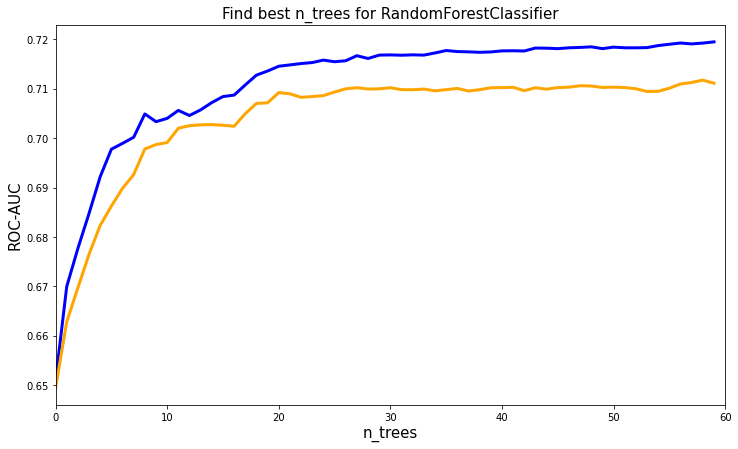

In [81]:
fig = plt.figure(figsize=(12, 7))

plt.title("Find best n_trees for RandomForestClassifier", size=15)
plt.plot(train_scores, linewidth=3, label="train-score", color="blue")
plt.plot(valid_scores, linewidth=3, label="valid-score", color="orange")
plt.xlabel("n_trees", size=15)
plt.ylabel("ROC-AUC", size=15)
plt.xlim(0, len(train_scores))

In [82]:
scores_lvl_2 = pd.DataFrame({
    "lgbm_model": oof_predictions,
    "xgb_model": oof_predictions_xgb,
    "cat_model": oof_predictions_cat,
    "rfc_model": oof_predictions_rfc,
})

corr_lb = scores_lvl_2.corr()

In [83]:
corr_lb

,lgbm_model,xgb_model,cat_model,rfc_model
lgbm_model,1.000000,0.928553,0.952672,0.857879
xgb_model,0.928553,1.000000,0.915806,0.795022
cat_model,0.952672,0.915806,1.000000,0.853868
rfc_model,0.857879,0.795022,0.853868,1.000000


### Level 2

In [84]:
x_train_LR, x_valid_LR = train_test_split(
    scores_lvl_2, train_size=0.7, shuffle=True, random_state=2177
)
y_train_LR, y_valid_LR = train_test_split(
    y_train, train_size=0.7, shuffle=True, random_state=2177
)

In [85]:
# 'liblinear', 'newton-cg', 'sag', 'saga' and 'lbfgs'
model_level2_logreg = LogisticRegression(max_iter=100, solver='lbfgs', random_state=2177)

In [86]:
model_level2_logreg.fit(x_train_LR, y_train_LR)

LogisticRegression(random_state=2177)

In [87]:
preds_logreg = model_level2_logreg.predict_proba(x_valid_LR)

In [88]:
print(f"LogReg Score = {round(roc_auc_score(y_valid_LR, preds_logreg[:, 1]), 4)}")

LogReg Score = 0.7153


#### XGBoost lvl 2

In [89]:
model_level2_xgb = xgb.XGBClassifier(n_estimators=10, max_depth=2, seed=2177)

In [90]:
model_level2_xgb.fit(x_train_LR, y_train_LR)

[19:45:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=2177,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2177,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [91]:
preds_level2_xgb = model_level2_xgb.predict_proba(x_valid_LR)

In [92]:
print(f"XGB Score = {round(roc_auc_score(y_valid_LR, preds_level2_xgb[:, 1]), 4)}")

XGB Score = 0.7147


### Выводы
Результат не сильно отличается от предыдущего, хотя корреляции с Random forest ниже чем между другими, т.е.  стабильность должна возрасти